In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Utils methods

## Crossover estimation Analysis
For defenition of crossovers we suggest to use the following functions based on ReLU function.

$$
f(x, R, C) = \frac{log(1 + e^{R (x - C)})*(x-C)}{R   \sqrt{1 + (x-C)^2}},
$$
where $R$ is coefficient which is proportonal to sharpness (rigidity) of a DFA crossover, $C$ is position of the crossover. And reversed version as follwing

$$
f_{rev}(x, R, C) = \frac{log(1 + e^{R (x - C)})(x-C)}{ - R   \sqrt{1 + (x-C)^2}},
$$

With this approach, when $x$ is too large, an overflaw may be detected in in exp. We will carry out transformations of the logarithm in function. 

$$
\mathrm{log}(1 + e^{x}) = 
\begin{cases}
x + \mathrm{log}(1 + e^{-x}) & \text{if } x > 0, \\
\mathrm{log}(1 + e^{x})      & \text{if } x \leq 0.
\end{cases}
$$

The expression $\log(1 + \exp(-|x|))$ is always numerically stable because $-|x| \leq 0$.

Based on this functions we defined the folling function $tf$ which can be ased as base element for fluctuation characteristic approximation.

$$
tf(x, R, C_1, C_2) = - f(x, R, C) - f_{rev}(x, R, C)
$$

### Single crossover case

The single crossover case can be defined as following:

$$
y(x, R_{12}, C_{12}, S_1, S_2) = y_0 + x S_1 * tf(x, R_{12}, -\infty, C_{12}) + S_2 * tf(x, R_{12}, C_{12}, \infty),
$$

where $y_0$ is function value if $x = 0$, $S_i$ is slope of $i$-th section of DFA, $C_{ij}$ is crossover possition between sections $i$ and $j$, $R_{ij}$ is sharpness of crossover between sections $i$ and $j$.

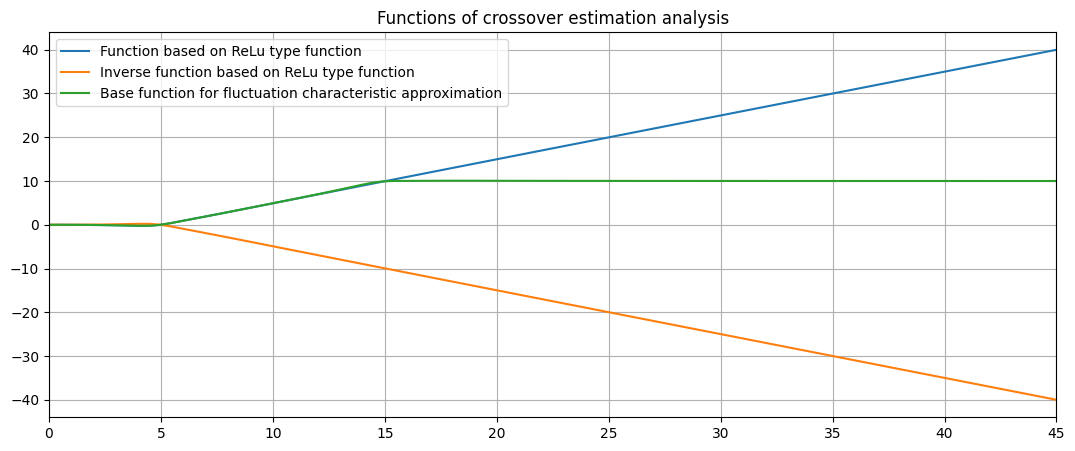

In [4]:
from StatTools.analysis import(
    f_fcn_without_overflaw,
    f_fcn,
    rev_f_fcn,
    tf_minus_inf,
    tf_plus_inf,
    ff_base_appriximation,
    cross_fcn_sloped,
    ff_params,
    var_estimation,
    analyse_cross_ff

) 

t = np.linspace(0, 45, num=101, endpoint=True)
y=np.linspace(-20, 100, num=101, endpoint=True)
slope_ij=[1.5,1,0.75]
C_ij=[5,15]
R_ij=[1,1,1]
fig, axs = plt.subplots()
plt.title("Functions of crossover estimation analysis")
fig.set_size_inches(13,5)
c_i=[c_i for c_i in C_ij]
slope_i=[slope_i for slope_i in slope_ij]
r_i=[r_i for r_i in R_ij]
all_values=c_i+slope_i+r_i
plt.plot(t,f_fcn(t,R_ij[0],C_ij[0]),label='Function based on ReLu type function')
plt.plot(t,rev_f_fcn(t,R_ij[0],C_ij[0]),label='Inverse function based on ReLu type function')
plt.plot(t,ff_base_appriximation(t,R_ij[0],C_ij[0],C_ij[1]),label='Base function for fluctuation characteristic approximation')
plt.grid()
plt.legend()
plt.xlim(0, 45)
plt.show()

## Function with multiple crossovers

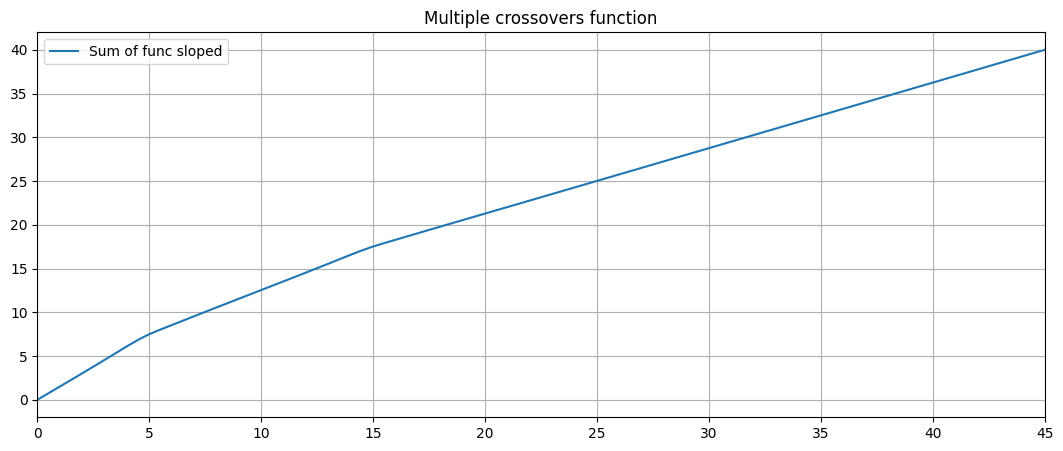

In [5]:
fig, axs = plt.subplots()
fig.set_size_inches(13,5)
plt.plot(t,cross_fcn_sloped(t,0,*all_values,crossover_amount=len(C_ij)),label='Sum of func sloped')
plt.title("Multiple crossovers function")
plt.grid()
plt.legend()
plt.xlim(0, 45)
plt.show()


## Functions with one crossover point

for example, plot a function with the following parameters: $y_0 = 0$, $C_{1_1} = 4$, $C_{1_2} = 10$, $S_1 = [1.5 , 1]$, $S_2 = [0.75 , 0.5]$, $R_{1_1} = 1$ and $R_{1_2} = 5$ 

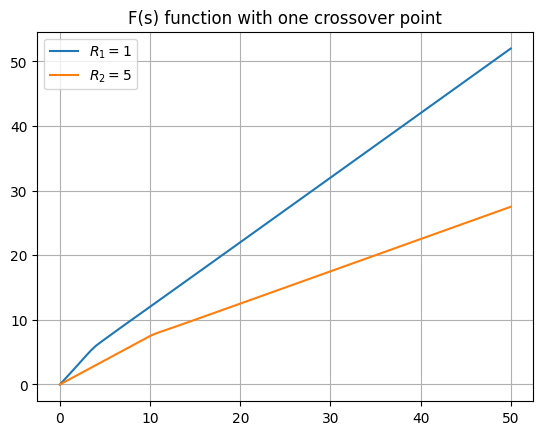

In [6]:
def plot_single_cross_example():
    intercept = [0] 
    C_11 = [4]
    C_12=[10]
    slope_1 = [1.5,1]
    slope_2 = [0.75,0.5]
    R_11=[1,1]
    R_12=[5,5]
    all_values_1=C_11+slope_1+R_11
    all_values_2=C_12+slope_2+R_12
    x = np.linspace(0, 50, num=101, endpoint=True)
    y_10 = cross_fcn_sloped(x, intercept, *all_values_1,crossover_amount=len(C_11))
    y_sev_c=cross_fcn_sloped(x,intercept,*all_values_2,crossover_amount=len(C_12))
    fig, ax = plt.subplots()
    plt.plot(x, y_10 , label="$R_{1} = 1$")
    plt.plot(x,y_sev_c, label="$R_{2} = 5$")
    plt.grid(which='both')
    plt.title("F(s) function with one crossover point")
    plt.legend()
    plt.show()
plot_single_cross_example()

## Approximation

Fluctuation Function Approximation via Non-Linear Least Squares

To estimate the parameters of the multi-crossovers fluctuation function model, using a non-linear least squares fitting approximation based on the based element function for fluctuation characteristic. The fitting is performed in the logarithmic area.

Given empirical fluctuation data $ F(S) $  measured at scales $ S $, we minimize the sum of squared residuals between the synthetic and model-predicted logarithmic fluctuation values:

$$
\min \sum_{i=1}^{N} \left[ \log_{10} F_{\text{synt}}(S_i) - y\bigl( \log_{10} F_{\text{pred}}(s); \text{fit params} \bigr) \right]^2,
$$

where $ y(x; \text{fit params}) $ is the model function built from the base element $ tf(x, R, C_1, C_2) $, and $ \text{fit params} $ includes the intercept $ y_0 $, crossover positions $ C_{ij} $, segment slopes $ S_i $ (Hurst coefficients), and ridigity parameters $ R_{ij} $.


Set the initial values for approximation:

-  $ \log_{10} S_{\min} \leq C_{ij} \leq \log_{10} S_{\max} $,
-  $ 0 \leq Slopes \leq 5 $,
- Ridigity parameters satisfy $ R_{ij} \geq 1 $ to avoid overflow in the exponential terms.


The fitting returns:
- Best-fit parameters,
- Standard errors from the covariance matrix,
- Residuals $ \Delta  = F_{\text{synt}} - 10^{\,y(\log_{10} S; \hat{\text{parameters}})} $.



Plot the fluctuation function with fitted parameters. Compare the plots with synthetic fluctuation function data and fitted data by approximation.

In [7]:

from StatTools.visualization import plot_ff

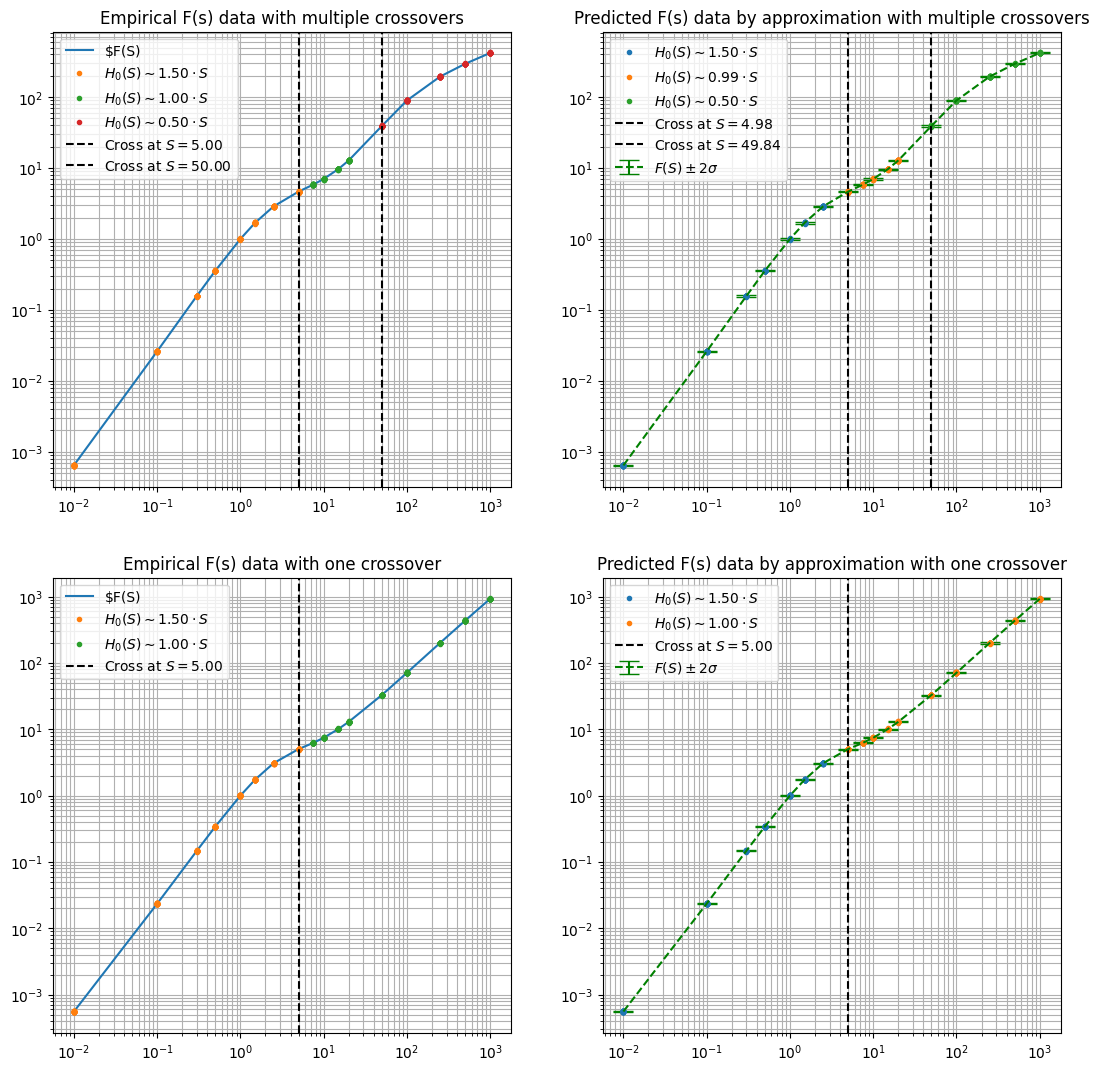

In [8]:

tst_s = np.array(
    [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2.5, 5, 7.5, 10, 15, 20, 50, 100, 250, 500, 1000]
)
y_0 = 0
cross = np.array([5, 50])
cross_1=np.array([5])
cross_log_1=list(np.log10(cross_1))
cross_log = list(np.log10(cross))
slope = [1.5, 1, 0.5]
slope_1=[1.5,1]
r = [1, 5, 1]
r_1=[1,10]
all_values_1=list(np.log10((cross_1))) + slope_1 + r_1
tst_h_multiple_1 = 10 ** cross_fcn_sloped(
    np.log10(tst_s), y_0, *all_values_1, crossover_amount=len(cross_1)
)
all_values = list(np.log10((cross))) + slope + r
tst_h_multiple = 10 ** cross_fcn_sloped(
    np.log10(tst_s), y_0, *all_values, crossover_amount=len(cross)
)


cross_error = [0, 0]
slope_error = [0, 0, 0]
r_error = [0, 0, 0]

cross_error_1=[0]
slope_error_1=[0,0]
r_error_1=[0,0]

cross_list_1 = [
    var_estimation(value=10**v, stderr=e) for v, e in zip(cross_log_1, cross_error_1)
]
slopes_list_1 = [var_estimation(value=v, stderr=e) for v, e in zip(slope_1, slope_error_1)]
ridigity_list_1 = [var_estimation(value=v, stderr=e) for v, e in zip(r_1, r_error_1)]

ff_params_new_1 = ff_params(
    intercept=var_estimation(value=y_0, stderr=0),
    cross=cross_list_1,
    slopes=slopes_list_1,
    ridigity=ridigity_list_1,
)
tst_hr_multiple_approx = 1 + np.random.normal(0, 0.01, (20, len(tst_h_multiple)))
tst_h_multiple = tst_hr_multiple_approx * tst_h_multiple

cross_list = [
    var_estimation(value=10**v, stderr=e) for v, e in zip(cross_log, cross_error)
]
slopes_list = [var_estimation(value=v, stderr=e) for v, e in zip(slope, slope_error)]
ridigity_list = [var_estimation(value=v, stderr=e) for v, e in zip(r, r_error)]

ff_params_new = ff_params(
    intercept=var_estimation(value=y_0, stderr=0),
    cross=cross_list,
    slopes=slopes_list,
    ridigity=ridigity_list,
)

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(13,13)

plot_ff(tst_h_multiple, tst_s, ff_params_new, ax=axs[0,0])
ff_parameters_approx, residuals_approx = analyse_cross_ff(
    tst_h_multiple, tst_s, crossover_amount=len(cross)
)


plot_ff(
    tst_h_multiple,
    tst_s,
    ff_parameter=ff_parameters_approx,
    residuals=residuals_approx,
    ax=axs[0,1]
)
axs[0,0].set_title("Empirical F(s) data with multiple crossovers")
tst_hr_multiple_approx_1 = 1 + np.random.normal(0, 0.01, (20, len(tst_h_multiple_1)))
tst_h_multiple_1 = tst_hr_multiple_approx_1 * tst_h_multiple_1
plot_ff(tst_h_multiple_1, tst_s, ff_params_new_1, ax=axs[1,0])
ff_parameters_approx_1, residuals_approx_1 = analyse_cross_ff(
    tst_h_multiple_1, tst_s, crossover_amount=len(cross_1)
)

axs[0,1].set_title("Predicted F(s) data by approximation with multiple crossovers")
axs[1,0].set_title("Empirical F(s) data with one crossover")
plot_ff(
    tst_h_multiple_1,
    tst_s,
    ff_parameter=ff_parameters_approx_1,
    residuals=residuals_approx_1,
    ax=axs[1,1]
)
axs[1,1].set_title("Predicted F(s) data by approximation with one crossover")
plt.show()
